<a href="https://colab.research.google.com/github/viviakemik/machine-learning/blob/main/ML_Aplicacoes_em_Financas_projeto2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Aprendizado de Máquina com Aplicações em Finanças (2024)



----------------------------
 Long Short Term Memory (Segunda parte)

Alunos:
* Viviani Kasahara
* Angelo Jonathan Diaz Soto







In [ ]:
# @title
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

!pip install tensorflow > /dev/null 2>&1
!pip install polygon-api-client > /dev/null 2>&1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4095    0  4095    0     0  11308      0 --:--:-- --:--:-- --:--:-- 11312
100  517k  100  517k    0     0   284k      0  0:00:01  0:00:01 --:--:--  677k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4027    0  4027    0     0   9106      0 --:--:-- --:--:-- --:--:--  9110
100  392k  100  392k    0     0   187k      0  0:00:02  0:00:02 --:--:--  412k


# 📑 **Conteúdo** <a class='anchor' id='top'></a>
- [1. Introdução e Objetivo](#intro)
- [2. Carregamento dos dados](#carregamento)
- [3. Preparação dos dados](#preparacao)
    - [3.1. Adição de colunas para datas](#adicaodatas)
    - [3.2. Remoção de dados duplicados](#duplicados)
    - [3.3. Remoção de NA](#na)
    - [3.4. Adição de indicadores](#indicadores)
        - [3.4.1. Stochastic Oscillator](#stoch)
        - [3.4.2. Bollinger Bands](#bbands)
        - [3.4.3. Relative Strength Index](#rsi)
        - [3.4.4. Average Directional Movement Index](#adx)
        - [3.4.5. On-Balance Volume](#obv)
        - [3.4.6. Average True Range](#obv)
        - [3.4.7. Simple Moving Average](#sma)
        - [3.4.8. Exponential Moving Average](#ema)
        - [3.4.9. Accumulation/Distribution Line](#ad)
        - [3.4.10. Aroon Indicator](#aroon)
    - [3.5. Estacionariedade](#estacionariedade)
        - [3.5.1. Fractional Differencing](#fracdiff)
    - [3.6. Standardization](#Standardization)
    - [3.7. Selection Feature](#featuresel)
        - [3.7.1. Regressão Lasso (LassoCv)](#lasso)
        - [3.7.2. SelectKBest (selectkbest)](#lasso)
- [4. Long Short-Term Memory](#lstm)
    - [4.1. Neural Network](#nn)
    - [4.2. Recurrent Neural Network](#rnn)
    - [4.3. Long Short-Term Memory](#lstm)
    - [4.4. Comparação com baseline](#baseline)
    - [4.5. Previsão de preços](#previsao)

# 📝 **1. Introdução e Objetivo** <a class='anchor' id='intro'></a> [↑](#top)


As flutuações dos preços das ações são incertas e o principal desafio é reunir informações multifacetadas para construir um modelo viável para previsões precisas (tarefa complexa e desafiadora).
O objetivo desse projeto é fazer a recomendação de ativos baseados na previsão de preços utilizando redes neurais



In [ ]:
from IPython.display import display

import pandas as pd
import numpy as np
import talib as ta

from statsmodels.tsa.stattools import adfuller, kpss

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'colab'

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

# 📤 **2. Carregamento dos dados** <a class='anchor' id='carregamento'></a> [↑](#top)



*   <u>**GLD**</u> (*SPDR Gold Shares ETF*): é um fundo negociado em bolsa (ETF) que visa rastrear o preço do ouro em barras

*   <u>**PDBC**</u>: é um fundo negociado em bolsa (ETF) que oferece exposição a um portfólio diversificado de futuros de commodities sem emitir um formulário fiscal K-1, o que é atraente para muitos investidores baseados nos EUA. Este ETF é frequentemente utilizado como forma de obter ampla exposição a mercadorias, abrangendo setores como energia, metais e agricultura.

* <u>**SLV**</u> (iShares Silver Trust ETF): é um fundo negociado em bolsa (ETF) projetado para rastrear o preço da prata. Permite aos investidores obter exposição à prata como mercadoria sem comprar e armazenar diretamente prata física, o que pode ser caro e complicado.


In [ ]:
df_gld = pd.read_parquet('/content/GLD_2020-04-07_2022-04-06.parquet')
df_gld = df_gld.set_index("DATE")
df_gld = df_gld.drop(["a", "op", "t"], axis=1)
df_gld.shape

(279478, 7)

In [ ]:
df_pdbc = pd.read_parquet('/content/PDBC_2020-04-07_2022-04-06.parquet')
df_pdbc = df_pdbc.set_index("DATE")
df_pdbc = df_pdbc.drop(["a", "op", "t"], axis=1)
df_pdbc.shape

(180485, 7)

In [ ]:
df_slv = pd.read_parquet('/content/SLV_2020-04-07_2022-04-06.parquet')
df_slv = df_slv.set_index("DATE")
df_slv = df_slv.drop(["a", "op", "t"], axis=1)
df_slv.shape

(301265, 7)

In [ ]:
print(df_gld.columns)

Index(['VOLUME', 'VW', 'OPEN', 'CLOSE', 'HIGHT', 'LOW', 'TRANSACTIONS'], dtype='object')


<style>
  table {
    width: 100%;
    border-collapse: collapse;
    font-size: 22px;
  }
  th, td {
    border: 1px solid black;
    padding: 8px;
    text-align: left;
    word-wrap: break-word;
  }
  th {
    width: 20%;
  }
  td {
    width: 30%;
  }
</style>

<table border="1">
  <thead>
    <tr>
      <th>Coluna</th>
      <th>Descrição</th>
      <th>Insight</th>
      <th>Indicador Técnico</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><strong>VOLUME</strong></td>
      <td>O volume indica o nível de interesse em um ativo. Volumes de <br>negociação mais elevados estão frequentemente correlacionados <br>com tendências mais fortes ou movimentos de preços (volatilidade).</td>
      <td>Os ativos com volumes mais elevados são normalmente mais líquidos, <br>o que significa que as alterações de preços têm maior probabilidade de <br>serem sustentáveis. Picos repentinos de volume podem preceder <br>movimentos significativos de preços.</td>
      <td>Indicadores técnicos como o Volume On-Balance (OBV) ou a Linha de <br>Acumulação/Distribuição usam o volume para avaliar a pressão de compra/venda,<br> que pode ser preditiva da direção futura dos preços.</td>
    </tr>
    <tr>
      <td><strong>OPEN</strong></td>
      <td>O preço de abertura serve como referência para a faixa de negociação <br>e o sentimento do dia. Uma abertura forte pode indicar otimismo, <br>enquanto uma abertura fraca pode sugerir baixa.</td>
      <td>Uma abertura forte sinaliza sentimento de alta, enquanto uma abertura <br>fraca sugere potencial para uma tendência de baixa. Comparar a abertura <br>com o fechamento anterior ajuda a identificar o momentum do mercado.</td>
      <td>Indicadores de Tendência: Comparar o preço de abertura com o fecho anterior ajuda <br>a identificar lacunas, que podem ser indicativas do sentimento do mercado ou de <br>mudanças de dinâmica. As lacunas de preços entre a abertura e o fechamento <br>geralmente sinalizam continuações ou reversões de tendências.</td>
    </tr>
    <tr>
      <td><strong>HIGH and LOW</strong></td>
      <td>Os preços altos e baixos dentro de um período mostram a <br>volatilidade e a faixa de preço do ativo. Faixas de preços maiores <br>geralmente sugerem maior atividade de mercado e possíveis reversões <br>de preços.</td>
      <td>Máximos e mínimos refletem níveis de suporte e resistência e podem indicar <br> volatilidade, ajudando os traders a antecipar reversões de preços ou <br>rompimentos.</td>
      <td>Momentum do preço: Esses valores contribuem para indicadores de momentum, <br>como o Average True Range (ATR), que pode ajudar a prever a força ou fraqueza <br>das tendências.</td>
    </tr>
    <tr>
      <td><strong>CLOSE</strong></td>
      <td>O preço de fechamento é frequentemente visto como o preço mais <br>significativo de um período de negociação, refletindo o consenso do <br>mercado.</td>
      <td>Os preços de fechamento são considerados os indicadores mais confiáveis <br> do sentimento e direção do mercado. Eles ajudam a definir o sentimento do <br>fechamento do mercado.</td>
      <td>Médias Móveis: Os preços de fechamento são usados ​​para calcular médias <br> móveis (como as médias móveis de 50 e 200 dias), que são indicadores <br>comumente usados ​​para análise de tendências e previsões de reversão.</td>
    </tr>
    <tr>
      <td><strong>VW</strong></td>
      <td>Preço Médio Ponderado por Volume - VWAP. O VWAP serve como um <br>preço de referência, mostrando o preço médio pago por ação, ajustado <br> pelo volume. Muitos traders institucionais buscam negociar ao redor do <br>VWAP para evitar impacto no mercado, então os preços frequentemente <br>retornam para o VWAP ao longo do dia.</td>
      <td>O VWAP ajuda a confirmar tendências, e preços acima do VWAP são vistos <br>como sinal de alta, enquanto preços abaixo do VWAP são considerados <br>sinal de baixa.</td>
      <td>Confirmação de tendência: o VWAP é usado para determinar se uma <br>tendência é legítima. Os preços acima do VWAP podem indicar um <br>sentimento de alta, enquanto os preços abaixo podem indicar uma baixa.</td>
    </tr>
    <tr>
      <td><strong>TRANSAÇÕES</strong></td>
      <td>O número de transações pode indicar o nível de atividade no mercado. <br>Uma alta contagem de transações com preços estáveis sugere consolidação, <br>enquanto transações altas com preços em mudança podem indicar um <br> possível rompimento ou reversão.</td>
      <td>Um aumento nas transações juntamente com movimento de preços valida <br>as tendências, ajudando a prever o movimento sustentado dos preços.</td>
      <td>Sentimento do Mercado: Um aumento no número de transações juntamente <br>com o movimento dos preços pode validar tendências (forte interesse de <br>compra ou venda), ajudando potencialmente a prever o movimento sustentado <br>dos preços.</td>
    </tr>
  </tbody>
</table>


# 🗂 **3. Preparação dos dados** <a class='anchor' id='preparacao'></a> [↑](#top)


## **3.1. Adição de colunas para datas** <a class='anchor' id='preparacao'></a>

In [ ]:
# @title
def new_time_periods(df):

    df_ = df.copy()
    df_['YEARMONTHDAY'] = [dt.date().isoformat() for dt in df_.index]
    df_['YEARMONTH'] = [f"{dt.year}-{dt.month:02d}" for dt in df_.index]
    df_['WEEK'] = [np.where(dt.date().day <= 7,'s1',
                       np.where(dt.date().day <= 14,'s2',
                                np.where(dt.date().day <= 21,'s3',
                                         's4'))) for dt in df_.index]

    col_list = df_.columns.tolist()
    first_cols = ['YEARMONTHDAY', 'YEARMONTH', 'WEEK']
    columns = list(set(col_list) - set(first_cols))
    new_order = first_cols + columns
    df_ = df_[new_order]

    return df_

In [ ]:
df_gld = new_time_periods(df_gld)
df_pdbc = new_time_periods(df_pdbc)
df_slv = new_time_periods(df_slv)

In [ ]:
print(df_gld["YEARMONTH"].unique())
print(df_pdbc["YEARMONTH"].unique())
print(df_slv["YEARMONTH"].unique())

['2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09' '2020-10'
 '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04' '2021-05'
 '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11' '2021-12'
 '2022-01' '2022-02' '2022-03' '2022-04']
['2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09' '2020-10'
 '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04' '2021-05'
 '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11' '2021-12'
 '2022-01' '2022-02' '2022-03' '2022-04']
['2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09' '2020-10'
 '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04' '2021-05'
 '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11' '2021-12'
 '2022-01' '2022-02' '2022-03' '2022-04']


## **3.2. Remoção de dados duplicados** <a class='anchor' id='duplicados'></a>

Por terem poucos casos, as linhas foram removidas caso alguma coluna não estiver preenchida

In [ ]:
df_gld = df_gld[~df_gld.index.duplicated()]
df_pdbc = df_pdbc[~df_pdbc.index.duplicated()]
df_slv = df_slv[~df_slv.index.duplicated()]

In [ ]:
print(df_gld.shape)
print(df_pdbc.shape)
print(df_slv.shape)

(277666, 10)
(180485, 10)
(299271, 10)


## **3.3. Remoção de NA** <a class='anchor' id='na'></a>

In [ ]:
df_gld = df_gld.dropna(axis=0)
df_pdbc = df_pdbc.dropna(axis=0)
df_slv = df_slv.dropna(axis=0)

In [ ]:
print(df_gld.shape)
print(df_pdbc.shape)
print(df_slv.shape)

(277660, 10)
(180485, 10)
(299265, 10)


In [ ]:
# @title
colors = {'red': '#ff207c', 'grey': '#42535b', 'blue': '#207cff', 'orange': '#ffa320', 'green': '#00ec8b'}
config_ticks = {'size': 14, 'color': colors['grey'], 'labelcolor': colors['grey']}
config_title = {'size': 18, 'color': colors['grey'], 'ha': 'left', 'va': 'baseline'}


def format_borders(plot):
    plot.spines['top'].set_visible(False)
    plot.spines['left'].set_visible(False)
    plot.spines['left'].set_color(colors['grey'])
    plot.spines['bottom'].set_color(colors['grey'])

def get_charts(stock_data, symbol):
    plt.rc('figure', figsize=(15, 7))

    fig, axes = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    fig.tight_layout(pad=3)

    date = stock_data['date']
    close = stock_data['price']
    vol = stock_data['volume'] / 1000000
    label = stock_data['date_label']

    plot_price = axes[0]
    plot_price.plot(date, close, color=colors['blue'], linewidth=1, label='Price')

    plot_vol = axes[1]
    plot_vol.bar(date, vol, width=3, color='green')

    xticks = np.arange(0, stock_data.shape[0], 1000)

    plot_price.yaxis.tick_right()
    plot_price.set_xticks(xticks)
    plot_price.set_xticklabels(label[xticks])
    plot_price.tick_params(axis='both', **config_ticks)
    plot_price.set_ylabel('Price', fontsize=14)
    plot_price.yaxis.set_label_position("right")
    plot_price.yaxis.label.set_color(colors['grey'])
    plot_price.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_price.set_axisbelow(True)

    plot_vol.yaxis.tick_right()
    plot_vol.set_xticks(xticks)
    plot_vol.tick_params(axis='both', **config_ticks)
    plot_vol.set_ylabel('Volume (in millions)', fontsize=14)
    plot_vol.yaxis.set_label_position("right")
    plot_vol.yaxis.label.set_color(colors['grey'])
    plot_vol.grid(axis='y', color='gainsboro', linestyle='-', linewidth=0.5)
    plot_vol.set_axisbelow(True)

    format_borders(plot_price)
    format_borders(plot_vol)

    fig.suptitle(symbol + ' Price (per minutes) and Volume', size=20, color=colors['grey'])

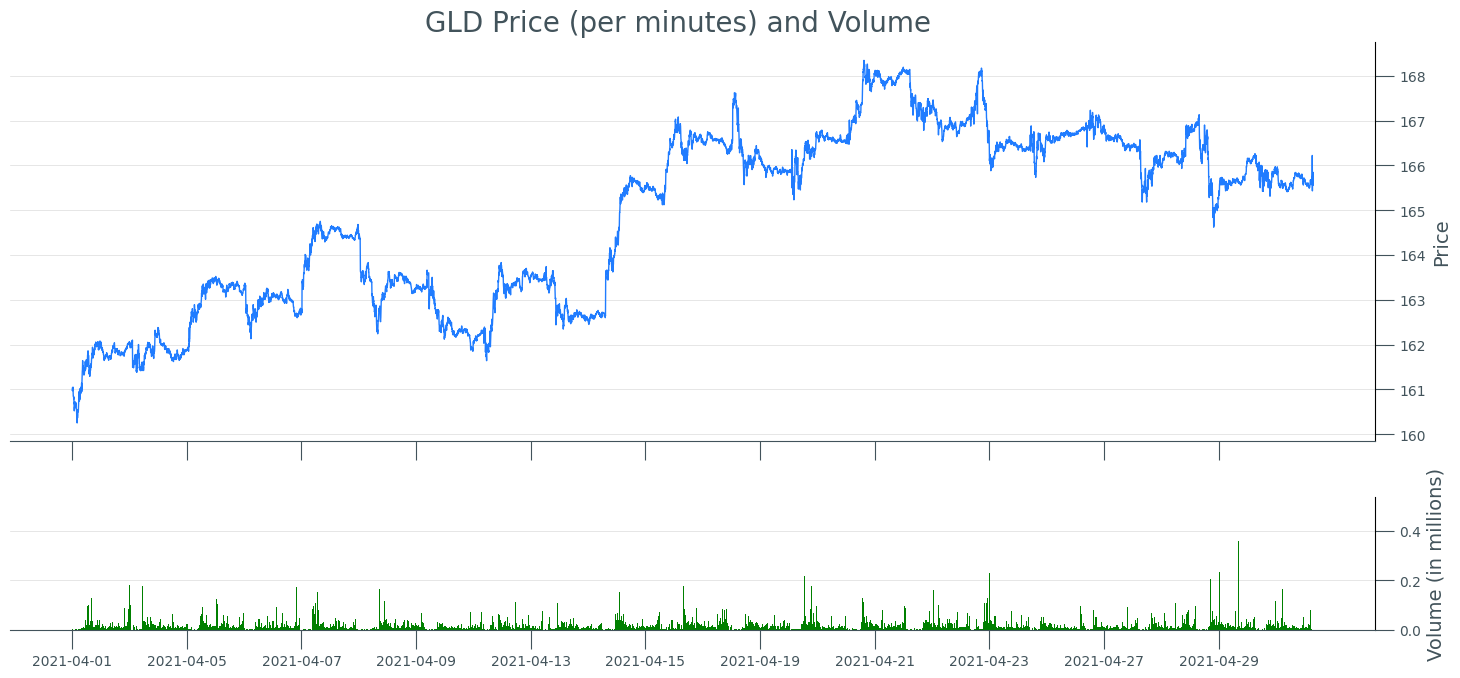

In [ ]:
year_month = '2021-04'
date_label = 'YEARMONTHDAY'
price      = 'CLOSE'
volume     = 'VOLUME'
rename     = ['date', 'date_label', 'price', 'volume']

stock_data = df_gld.loc[df_gld['YEARMONTH']== year_month, [date_label, price, volume]].reset_index()

stock_data.columns = rename
stock_data = stock_data.astype({'date': 'str', 'date_label': 'str', 'price': 'float', 'volume': 'int'}, copy = False)

get_charts(stock_data, 'GLD')

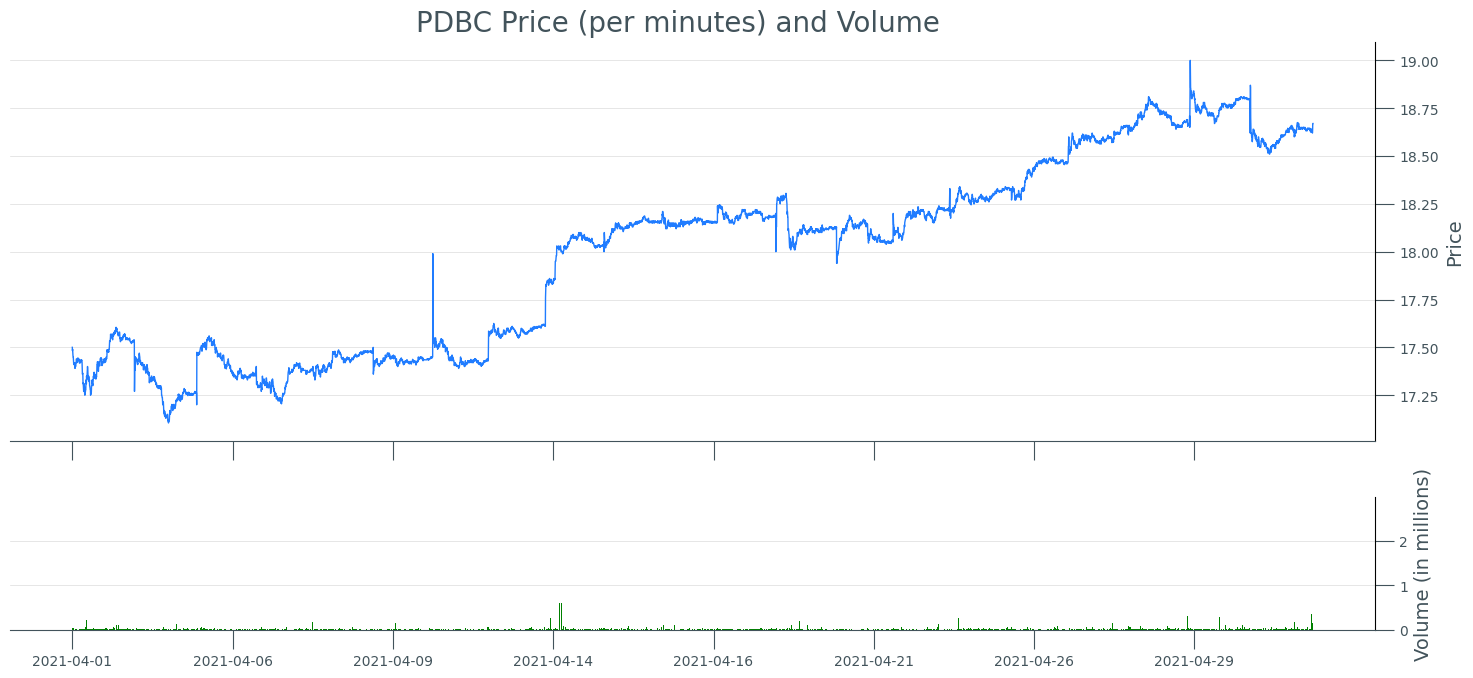

In [ ]:
year_month = '2021-04'
date_label = 'YEARMONTHDAY'
price      = 'CLOSE'
volume     = 'VOLUME'
rename     = ['date', 'date_label', 'price', 'volume']

stock_data = df_pdbc.loc[df_pdbc['YEARMONTH']== year_month, [date_label, price, volume]].reset_index()

stock_data.columns = rename
stock_data = stock_data.astype({'date': 'str', 'date_label': 'str', 'price': 'float', 'volume': 'int'}, copy = False)

get_charts(stock_data, 'PDBC')

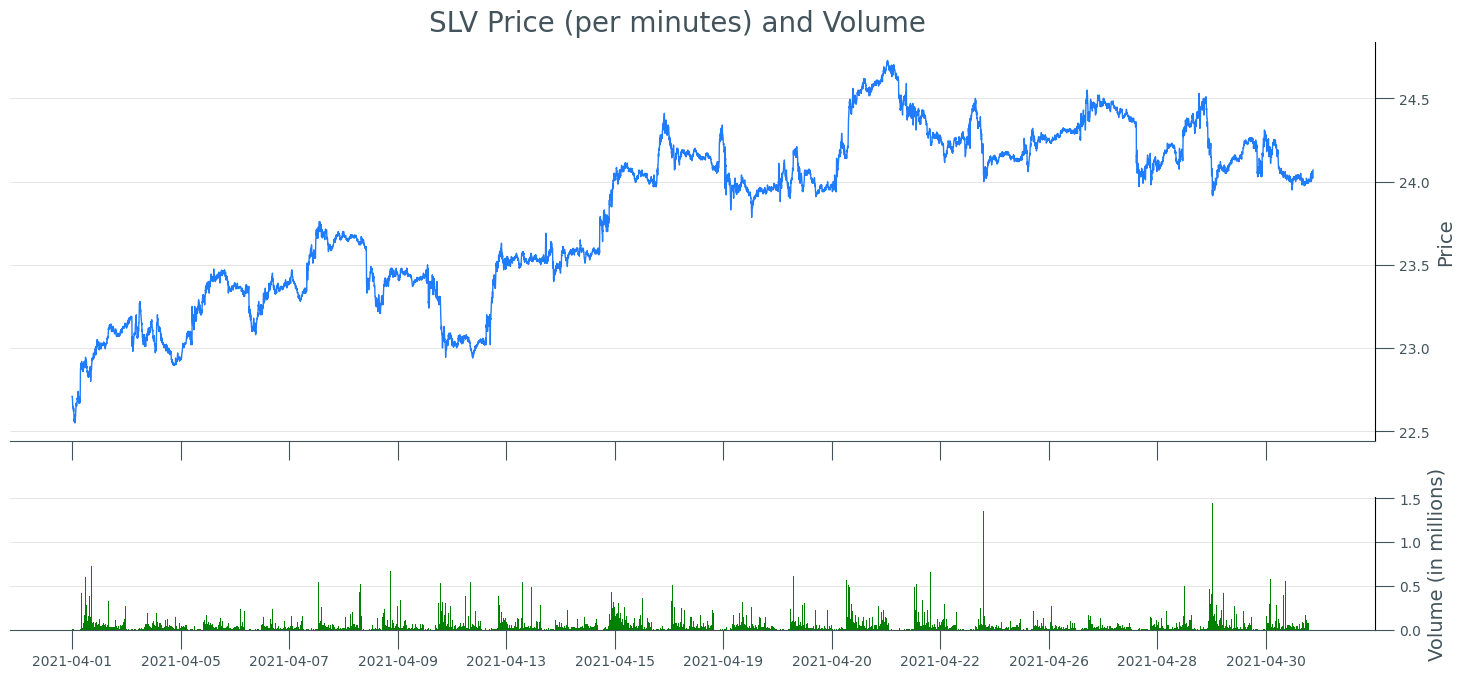

In [ ]:
year_month = '2021-04'
date_label = 'YEARMONTHDAY'
price      = 'CLOSE'
volume     = 'VOLUME'
rename     = ['date', 'date_label', 'price', 'volume']

stock_data = df_slv.loc[df_slv['YEARMONTH']== year_month, [date_label, price, volume]].reset_index()

stock_data.columns = rename
stock_data = stock_data.astype({'date': 'str', 'date_label': 'str', 'price': 'float', 'volume': 'int'}, copy = False)

get_charts(stock_data, 'SLV')

## **3.4. Adição de indicadores** <a class='anchor' id='indicadores'></a>

In [ ]:
# @title
def calculate_technical_indicators(df, vars_in = [], method = None, params = []):

    if method == None:
        return df

    if method == 'SMA':
        var_out = vars_in[0] + '_' + method + '_' + str(params[0])
        df[var_out] = ta.__dict__[method](df[vars_in[0]].values, timeperiod = params[0])
        return df

    if method == 'EMA':
        var_out = vars_in[0] + '_' + method + '_' + str(params[0])
        df[var_out] = ta.__dict__[method](df[vars_in[0]].values, timeperiod = params[0])
        return df

    if method == 'PLUS_DI':
        var_out = method + '_' + str(params[0])
        df[var_out] = ta.__dict__[method](high  = df[vars_in[0]].values,
                                          low   = df[vars_in[1]].values,
                                          close = df[vars_in[2]].values,
                                          timeperiod = params[0])
        return df

    if method == 'MINUS_DI':
        var_out = method + '_' + str(params[0])
        df[var_out] = ta.__dict__[method](high  = df[vars_in[0]].values,
                                          low   = df[vars_in[1]].values,
                                          close = df[vars_in[2]].values,
                                          timeperiod = params[0])
        return df

    if method == 'ADX':
        var_out = method + '_' + str(params[0])
        df[var_out] = ta.__dict__[method](high  = df[vars_in[0]].values,
                                          low   = df[vars_in[1]].values,
                                          close = df[vars_in[2]].values,
                                          timeperiod = params[0])
        return df

    if method == 'RSI':
        var_out = vars_in[0] + '_' + method + '_' + str(params[0])
        df[var_out] = ta.__dict__[method](df[vars_in[0]].values, timeperiod = params[0])
        return df

    if method == 'BBANDS':
        var_out_low = vars_in[0] + '_' + method + '_LOW_' + str(params[0]) + '_' + str(params[2])
        var_out_mid = vars_in[0] + '_' + method + '_MID_' + str(params[0])
        var_out_up = vars_in[0] + '_' + method + '_UP_' + str(params[0]) + '_' + str(params[1])
        df[var_out_up],df[var_out_mid],df[var_out_low] = ta.__dict__[method](df[vars_in[0]].values,
                                                                                 timeperiod = params[0],
                                                                                 nbdevup = params[1],
                                                                                 nbdevdn = params[2],
                                                                                 matype = params[3])
        return df

    if method == 'STOCH':
        var_out = vars_in[2] + '_' + method + '_' + str(params[0]) + '_' + str(params[1])

        df[var_out], df[var_out] = ta.__dict__[method](high  = df[vars_in[0]].values,
                                                                  low   = df[vars_in[1]].values,
                                                                  close = df[vars_in[2]].values,
                                                                  fastk_period = params[0],
                                                                  slowk_period = params[1],
                                                                  slowk_matype = params[2],
                                                                  slowd_period = params[3],
                                                                  slowd_matype = params[4])
        return df

    if method == 'OBV':
        var_out = 'OBV'
        df[var_out] = ta.__dict__[method](df[vars_in[0]].values, df[vars_in[1]].values)
        return df

    if method == 'ATR':
        var_out = 'ATR_' + str(params[0])
        df[var_out] = ta.__dict__[method](high  = df[vars_in[0]].values,
                                          low   = df[vars_in[1]].values,
                                          close = df[vars_in[2]].values,
                                          timeperiod = params[0])
        return df

    if method == 'AD':
        var_out = 'AD'
        df[var_out] = ta.AD(high=df[vars_in[0]].values,
                            low=df[vars_in[1]].values,
                            close=df[vars_in[2]].values,
                            volume=df[vars_in[3]].values)
        return df

    if method == 'AROON':
        var_out_up = 'AROON_UP'
        var_out_down = 'AROON_DOWN'
        df[var_out_up], df[var_out_down] = ta.AROON(high=df[vars_in[0]].values,
                                                    low=df[vars_in[1]].values)
        return df

In [ ]:
df_gld = calculate_technical_indicators(df_gld, vars_in = ['HIGHT','LOW','CLOSE'], method = 'STOCH', params = [14, 3, 0, 3, 0])
df_gld = calculate_technical_indicators(df_gld, vars_in = ['CLOSE'], method = 'BBANDS', params = [20, 2, 2, 0])
df_gld = calculate_technical_indicators(df_gld, vars_in = ['CLOSE'], method = 'RSI', params = [14])
df_gld = calculate_technical_indicators(df_gld, vars_in = ['HIGHT','LOW','CLOSE'], method = 'PLUS_DI', params = [14])
df_gld = calculate_technical_indicators(df_gld, vars_in = ['HIGHT','LOW','CLOSE'], method = 'MINUS_DI', params = [14])
df_gld = calculate_technical_indicators(df_gld, vars_in=['HIGHT', 'LOW', 'CLOSE'], method='ADX', params=[14])
df_gld = calculate_technical_indicators(df_gld, vars_in=['CLOSE', 'VOLUME'], method='OBV')
df_gld = calculate_technical_indicators(df_gld, vars_in=['HIGHT', 'LOW', 'CLOSE'], method='ATR', params=[14])
df_gld = calculate_technical_indicators(df_gld, vars_in=['HIGHT', 'LOW', 'CLOSE'], method='ADX', params=[14])
df_gld = calculate_technical_indicators(df_gld, vars_in = ['CLOSE'], method = 'EMA', params = [14])
df_gld = calculate_technical_indicators(df_gld, vars_in = ['CLOSE'], method = 'SMA', params = [14])
df_gld = calculate_technical_indicators(df_gld, vars_in = ['HIGHT', 'LOW', 'CLOSE', 'VOLUME'], method = 'AD', params = [14])
df_gld = calculate_technical_indicators(df_gld, vars_in=['HIGHT', 'LOW'], method='AROON')

num_nan_rows = df_gld.isna().any(axis=1).sum()
print(f"Total number of rows with NaN values: {num_nan_rows}")
print(df_gld.columns)

Total number of rows with NaN values: 27
Index(['YEARMONTHDAY', 'YEARMONTH', 'WEEK', 'VW', 'OPEN', 'CLOSE', 'LOW',
       'VOLUME', 'TRANSACTIONS', 'HIGHT', 'CLOSE_STOCH_14_3',
       'CLOSE_BBANDS_UP_20_2', 'CLOSE_BBANDS_MID_20', 'CLOSE_BBANDS_LOW_20_2',
       'CLOSE_RSI_14', 'PLUS_DI_14', 'MINUS_DI_14', 'ADX_14', 'OBV', 'ATR_14',
       'CLOSE_EMA_14', 'CLOSE_SMA_14', 'AD', 'AROON_UP', 'AROON_DOWN'],
      dtype='object')


In [ ]:
df_gld = df_gld.bfill()
num_nan_rows = df_gld.isna().any(axis=1).sum()
print(f"Total number of rows with NaN values: {num_nan_rows}")

Total number of rows with NaN values: 0


In [ ]:
df_gld.describe()

,VW,HIGHT,LOW,OPEN,CLOSE,TRANSACTIONS,VOLUME,CLOSE_STOCH_14_3,CLOSE_BBANDS_UP_20_2,CLOSE_BBANDS_MID_20,...,PLUS_DI_14,MINUS_DI_14,ADX_14,OBV,ATR_14,CLOSE_EMA_14,CLOSE_SMA_14,AD,AROON_UP,AROON_DOWN
count,277660.000000,277660.000000,277660.000000,277660.000000,277660.000000,277660.000000,2.776600e+05,2.776600e+05,277660.000000,277660.000000,...,277660.000000,277660.000000,277660.000000,2.776600e+05,277660.000000,277660.000000,277660.000000,2.776600e+05,277660.000000,277660.000000
mean,171.247512,171.275131,171.220248,171.247962,171.247619,134.003922,1.771290e+04,5.160276e+01,171.440691,171.246803,...,28.759867,28.711784,23.464256,-8.553919e+06,0.070108,171.247062,171.247061,8.134625e+06,49.718232,51.927254
std,7.410018,7.413583,7.406698,7.410201,7.410004,191.300486,3.445977e+04,2.856157e+01,7.435484,7.409227,...,12.396298,12.209348,9.825915,8.371985e+06,0.041945,7.409049,7.409441,4.875801e+06,36.322242,36.478471
min,154.567500,154.640000,154.500000,154.575000,154.500000,1.000000,1.000000e+02,-1.217199e-12,154.802563,154.705500,...,1.528391,1.306187,4.875087,-2.602313e+07,0.010867,154.694655,154.697143,-1.304732e+06,0.000000,0.000000
25%,166.099900,166.130000,166.075000,166.100000,166.100000,17.000000,2.189000e+03,2.559479e+01,166.266150,166.101246,...,20.057856,20.052817,16.191889,-1.466679e+07,0.039796,166.102769,166.101425,4.373873e+06,14.285714,14.285714
50%,169.775600,169.796750,169.750000,169.779450,169.770500,80.000000,8.314000e+03,5.246914e+01,169.935302,169.770175,...,26.376763,26.370255,21.371598,-9.664454e+06,0.061398,169.769813,169.770086,7.073162e+06,50.000000,50.000000
75%,177.010425,177.035000,176.990000,177.010000,177.010000,172.000000,2.039900e+04,7.780680e+01,177.164593,177.009981,...,34.943225,35.005579,28.622682,-3.187198e+06,0.089127,177.012228,177.013936,1.171080e+07,85.714286,85.714286
max,194.731100,194.880000,194.740000,194.740000,194.880000,9355.000000,2.766136e+06,1.000000e+02,195.011755,194.575500,...,94.903407,90.697664,74.479295,1.164461e+07,0.999153,194.541180,194.617857,2.144815e+07,100.000000,100.000000


In [ ]:
# @title
def plot_candlestick_with_indicators(df, indicator_columns, start_date=None, end_date=None):
    """
    Plots a Candlestick Chart with overlayed indicators.

    Parameters:
    df (pd.DataFrame): DataFrame with a date index and columns 'Open', 'High', 'Low', 'Close'.
    indicator_columns (list of str): The list of column names of the indicators to plot.
    start_date (str, optional): The start date for filtering the data. Default is None.
    end_date (str, optional): The end date for filtering the data. Default is None.
    """
    if start_date:
        df = df.loc[df.index >= start_date]
    if end_date:
        df = df.loc[df.index < end_date]

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.2,
                        row_heights=[0.7, 0.3])

    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['OPEN'],
        high=df['HIGHT'],
        low=df['LOW'],
        close=df['CLOSE'],
        name='Candlestick'
    ), row=1, col=1)

    colors = ['#5576FA', '#A5976F', '#FACF55', '#504C3F', '#676B7A', '#6E7DBA', '#6EBAA6', '#FA6E44', 'black', 'brown']

    for i, indicator_column in enumerate(indicator_columns):
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[indicator_column],
            mode='lines',
            name=indicator_column.title(),
            line=dict(color=colors[i % len(colors)], width=2)
        ), row=2, col=1)


    fig.update_layout(
        title=dict(text="Candlestick Chart with Overlayed Indicators", font=dict(size=20, family="Arial, bold")),
        xaxis_title="Date",
        yaxis_title="Price",
        xaxis2_title="Date",
        yaxis2_title="Indicator Values",
        xaxis=dict(tickangle=45, tickformat="%Y-%m-%d %H:%M"),
        legend=dict(
            font=dict(size=14),
            bgcolor='rgba(255, 255, 255, 0.8)',
            bordercolor='rgba(0, 0, 0, 0.5)',
            borderwidth=1
        ),
        template="plotly_white",
        width=1700,
        height=800
    )

    indicator_min = df[indicator_columns].min().min()
    indicator_max = df[indicator_columns].max().max()
    padding = (indicator_max - indicator_min) * 0.1  # 10% padding
    fig.update_yaxes(range=[indicator_min - padding, indicator_max + padding], row=2, col=1)

    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='#cfcfcf')
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='#cfcfcf')

    fig.show()

### **3.4.1. Stochastic Oscillator** <a class='anchor' id='stoch'></a>

O Oscilador Estocástico compara a posição de fechamento de um ativo em relação ao seu intervalo de preços durante um período específico. Ele é baseado na premissa de que, em um mercado em alta, os preços tendem a fechar perto do máximo do intervalo de preços, enquanto em um mercado em baixa, os preços tendem a fechar perto do mínimo do intervalo de preços.<br><br>

$$
\%K = \left( \frac{\text{Preço de Fechamento} - \text{Mínimo do Período}}{\text{Máximo do Período} - \text{Mínimo do Período}} \right) \times 100
$$<br>



%K: O valor do oscilador varia entre 0 e 100.

* <u>**Sobrevenda**</u>: Quando o %K está abaixo de 20, o ativo é considerado sobrevendido, indicando uma possível reversão para cima.
* <u>**Sobrecompra**</u>: Quando o %K está acima de 80, o ativo é considerado sobrecomprado, indicando uma possível reversão para baixo.<br><br>

Para suavizar o oscilador e reduzir o ruído, uma linha de sinal (%D) é frequentemente usada. A linha de sinal é uma média móvel simples do %K, geralmente calculada sobre 3 períodos.

In [ ]:
plot_candlestick_with_indicators(df_gld, ['CLOSE_STOCH_14_3'], start_date='2020-01-01', end_date='2020-04-08')

### **3.4.2. Bollinger Bands** <a class='anchor' id='bbands'></a>

1. <u>**Banda Superior (CLOSE_BBANDS_UP_20_2)**</u>: Esta banda representa o limite superior da faixa de preço com base no desvio padrão. Indica o nível de resistência onde o preço pode enfrentar pressão de venda.<br><br>
 $$
   \text{Upper Band} = \text{SMA}(n) + (K \times \text{Standard Deviation}(n))
 $$<br>
 onde \( K \) usado geralmente é 2 (= 2 standard deviations).<br><br>

2. <u>**Banda Média (CLOSE_BBANDS_MID_20)**</u>: Esta banda é a média móvel simples dos preços de fechamento. Representa a tendência central do preço durante o período de tempo especificado.<br><br>
 $$
   \text{Middle Band} = \text{SMA}(n)
 $$<br>
 onde \( n \) é o número de período (geralmente 20 períodos).<br><br>

3. <u>**Banda Inferior (CLOSE_BBANDS_LOW_20_2)**</u>: Esta banda representa o limite inferior da faixa de preço com base no desvio padrão. Indica o nível de suporte onde o preço pode enfrentar pressão de compra.<br><br>
$$
   \text{Lower Band} = \text{SMA}(n) - (K \times \text{Standard Deviation}(n))
$$


In [ ]:
plot_candlestick_with_indicators(df_gld, ['CLOSE_BBANDS_UP_20_2', 'CLOSE_BBANDS_MID_20', 'CLOSE_BBANDS_LOW_20_2'], start_date='2020-01-01', end_date='2020-04-08')

### **3.4.3. Relative Strength Index** <a class='anchor' id='rsi'></a>


O **Índice de Força Relativa (RSI)** é um indicador de momento que ajuda a identificar condições de sobrecompra ou sobrevenda.

1. **Calcule a Força Relativa (RS):**
   $$
   RS = \frac{\text{Ganho Médio nos últimos } n \text{ períodos}}{\text{Perda Média nos últimos } n \text{ períodos}}
   $$

2. **Calcule o RSI:**
   $$
   \text{RSI} = 100 - \frac{100}{1 + RS}
   $$

   onde:
   - \( n \) é o número de períodos (geralmente definido como 14).
   - **Ganho Médio** é a média de todos os ganhos nos últimos \( n \) períodos. Ganhos em períodos com queda de preço são contados como zero.
   - **Perda Média** é a média de todas as perdas nos últimos \( n \) períodos. Perdas em períodos com aumento de preço são contadas como zero.


**Interpretação**
- **RSI > 70**: Potencialmente sobrecomprado (pode indicar um sinal de venda).
- **RSI < 30**: Potencialmente sobrevendido (pode indicar um sinal de compra).
